# Prepare Python (and colab)

In [ ]:
# Youtube Downloader
# `youtube-dl` is a utility to download audio and video streams from youtube. 
# You can find it here: https://github.com/ytdl-org/youtube-dl
!curl -L "https://yt-dl.org/downloads/latest/youtube-dl" -o "/usr/local/bin/youtube-dl" > /dev/null 2>&1
!chmod a+rx "/usr/local/bin/youtube-dl" > /dev/null 2>&1
!apt-get install musescore > /dev/null 2>&1
!apt-get install xvfb > /dev/null 2>&1

import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.lines as lines
%matplotlib inline
import IPython.display as ipd
import numpy as np

import os
os.putenv('DISPLAY', ':99.0')
!start-stop-daemon --start --pidfile /var/run/xvfb.pid --make-pidfile --background --exec /usr/bin/Xvfb -- :99 -screen 0 1024x768x24 -ac +extension GLX +render -noreset  > /dev/null 2>&1

import music21

# music21 User settings
us = music21.environment.UserSettings()
us['musescoreDirectPNGPath'] = '/usr/bin/mscore'
us['directoryScratch'] = '/tmp'
us['autoDownload'] = 'allow' # necessary to parse() urls directly
# start x11 stuff
!sh -e /etc/init.d/x11-common start > /dev/null 2>&1

# Audio to Score Alignment



Here's an example of audio-to-score alignment using the DTW algorithm. Two python classes are constructed, a `Score` and an `Aligner` class. The `Score` is used to maintain a music21 score with its audio version in sync, so as to query sections of the audio by measures. The `Aligner` class is meant to ease the usage of the DTW algorithm. 

## Getting Bach Chorales (...from youtube)



In [ ]:
def youtube_downloader(urls, prefix, format='mp3', ytdl="/usr/local/bin/youtube-dl"):
    """Run the youtube downloader on all urls
    """
    
    if isinstance(urls,str):
        urls = [urls]
    print("Downloading...")
    filenames = []
    for i, url in enumerate(urls):
        out = f"{prefix}-{i}.{format}"
        print(url,out)
        flags = f" --output '{out}' "
        flags += f" --ignore-errors --extract-audio "
        flags += f" --audio-format {format} "
        os.system(f"{ytdl} {flags} {url}")
        filenames.append(out)
    print("Done.")
    return filenames

Get some youtube URLs 

In [ ]:
youtube_urls = [
"https://www.youtube.com/watch?v=DAf5sQ1ZsCY",
"https://www.youtube.com/watch?v=JamPSbdhLko",
"https://www.youtube.com/watch?v=MS3X0vy23dA",
"https://www.youtube.com/watch?v=L2cPibJzwbA",
]

In [ ]:
filenames = youtube_downloader(youtube_urls, prefix="bach_chorale-1")

Downloading...
https://www.youtube.com/watch?v=DAf5sQ1ZsCY bach_chorale-1-0.mp3
https://www.youtube.com/watch?v=JamPSbdhLko bach_chorale-1-1.mp3
https://www.youtube.com/watch?v=MS3X0vy23dA bach_chorale-1-2.mp3
https://www.youtube.com/watch?v=L2cPibJzwbA bach_chorale-1-3.mp3
Done.


In [ ]:
!ls *.mp3

bach_chorale-1-0.mp3  bach_chorale-1-2.mp3
bach_chorale-1-1.mp3  bach_chorale-1-3.mp3


## Getting a Bach Chorale Score (from kern to synced audio+music21)

### `Score` class

In [ ]:
class Score:
    """A class to keep a music21 score and its sonification in sync

    Initialization
    --------------------
    myscore = Score(input)

    From music21's converter.parse() docs:
        Simply provide a filename, URL, or text string and, 
        if the format is supported, a Score will be returned.

    Methods
    --------------------
    load(): load and convert a file/url into music21 score
    sonify(): sonifies the score using helper functions
    generate_tone(): basic synthesizer
    midi2hz(): converts midi to Hz
    listen(): displays audio using IPython
    show(): displays score using music21's show()
    bar_to_samples(): returns sample indices of specified measures
    play(): simplification of the listen+show+bar_to_samples methods

    """

    # initialize the class
    def __init__(self,file):
        self.sr = 22050      # sample rate 
        self.numbars = 0     # number of bars
        self.data = []       # kern data
        self.durations = []  # list of lists holding parts and their durations 
        self.pitches = []    # list of lists holdinf parts and their pitches
        self.barduration = 0 # duration of a bar (measure) in seconds 
        self.audio = None    # audio file
        self.load(file)      # load the kern file on initialization

    def load(self, file):
        self.file = file
        self.data = music21.converter.parse(self.file)
        self.barduration = self.data.measure(1).duration.quarterLength
        self.numbars = self.data.measure(-1).flat[-1].measureNumber + 1
        # treat each part separately
        for part in self.data.parts:
            
            # for each part store their notes
            durations = []
            pitches = []
            
            # generate each note separately and append
            for p in part.flat.notes:

                pch = self.midi2hz(p.pitch.midi)
                dur = p.duration.quarterLength
                
                durations.append(dur)
                pitches.append(pch)
        
            self.durations.append(durations)
            self.pitches.append(pitches)
        
        return self

    def sonify(self, sr=22050):
        """Sonify a kern file (needs music21)
        
        Parameters
        --------------------
        sr : samplerate (default 22050)

        Returns
        --------------------
        self.audio : (np.array) a synthesized version of the kern data 

        """

        parts = []

        # treat each part separately
        for pitches,durations in zip(self.pitches,self.durations):
            
            # for each part store theirnotes
            notes = []
            
            # generate each note separately and append
            for p,d in zip(pitches,durations):

                note = self.generate_tone(p,d)
                notes.append(note)
            
            # then, concatenate
            notes = np.concatenate(notes)

            # append to parts array
            parts.append(notes)


        # the audio is the sum of all parts together
        self.audio = np.array(np.sum(parts,axis=0))

        return self.audio
    
    def generate_tone(self, freq, dur, amp=1.0, phase=0.0):
        """
        Returns a tone with a sine oscillating at the specified frequency
        """
        x = np.linspace(0,dur,int(self.sr * dur))
        tone = amp * np.sin(2 * np.pi * freq * x + phase)
        return tone
    
    def midi2hz(self, n):
        """
        Converts midi to herz
        """
        return 440.0 * (2.0 ** ((n - 69.0) / 12.0))

    def listen(self,start=0,end=-1):
        """Plays a sound given a range (defaults to entire array)
        
        Parameters
        --------------------
        start : sample index to trim the array (default 0)
        end   : last sample index (default -1)
        """
        if self.audio is None:
            self.audio = self.sonify()
    
        ipd.display(ipd.Audio(self.audio[start:end],rate=self.sr))
    
    def show(self,start=0,end=-1):
        """Displays a music21 score range (defaults to entire score) 
        
        Parameters
        --------------------
        start : first measure index to trim the score (default 0)
        end   : last measure index (default -1)
        """
        if end == -1 or end > self.numbars:
            end = self.numbars
        self.data.measures(start, end).show()

    def bar_to_samples(self,start=0,end=-1):
        """Gets bar indices in samples

        Parameters
        --------------------
        start : start bar number (measures in music21)
        end : end bar number, idem
        
        Returns
        --------------------
        s,e : start and end sample indices
       """
        # get duration in seconds based on bar duration
        length = end - start # in bars
        dur = self.barduration * length # dur in seconds

        dur += self.barduration # include last bar

        s = int(start * self.barduration * self.sr) # start in samples
        e = dur * self.sr + s  # end in samples
        e = int(min(e, self.numbars * self.barduration * self.sr))

        return [s, e]

    def play(self,start=0,end=-1,show=True,listen=True):
        """ Play and show score with given bar range

        show : bool to display score
        listen: bool to display audio

        Returns
        --------------------
        if listen is false, the start and end point in samples are returned
        otherwise, play audio to using IPython display
        if show is true, display score using music21 show()
        """
        if show:
            # shameleslsy add an extra bar
            self.show(start, end+1)
        
        s,e = self.bar_to_samples(start, end)
        
        if listen:
            self.listen(s, e)
        
        return [s,e]

### Usage

In [ ]:
source = Score("https://raw.githubusercontent.com/craigsapp/bach-370-chorales/master/kern/chor001.krn")

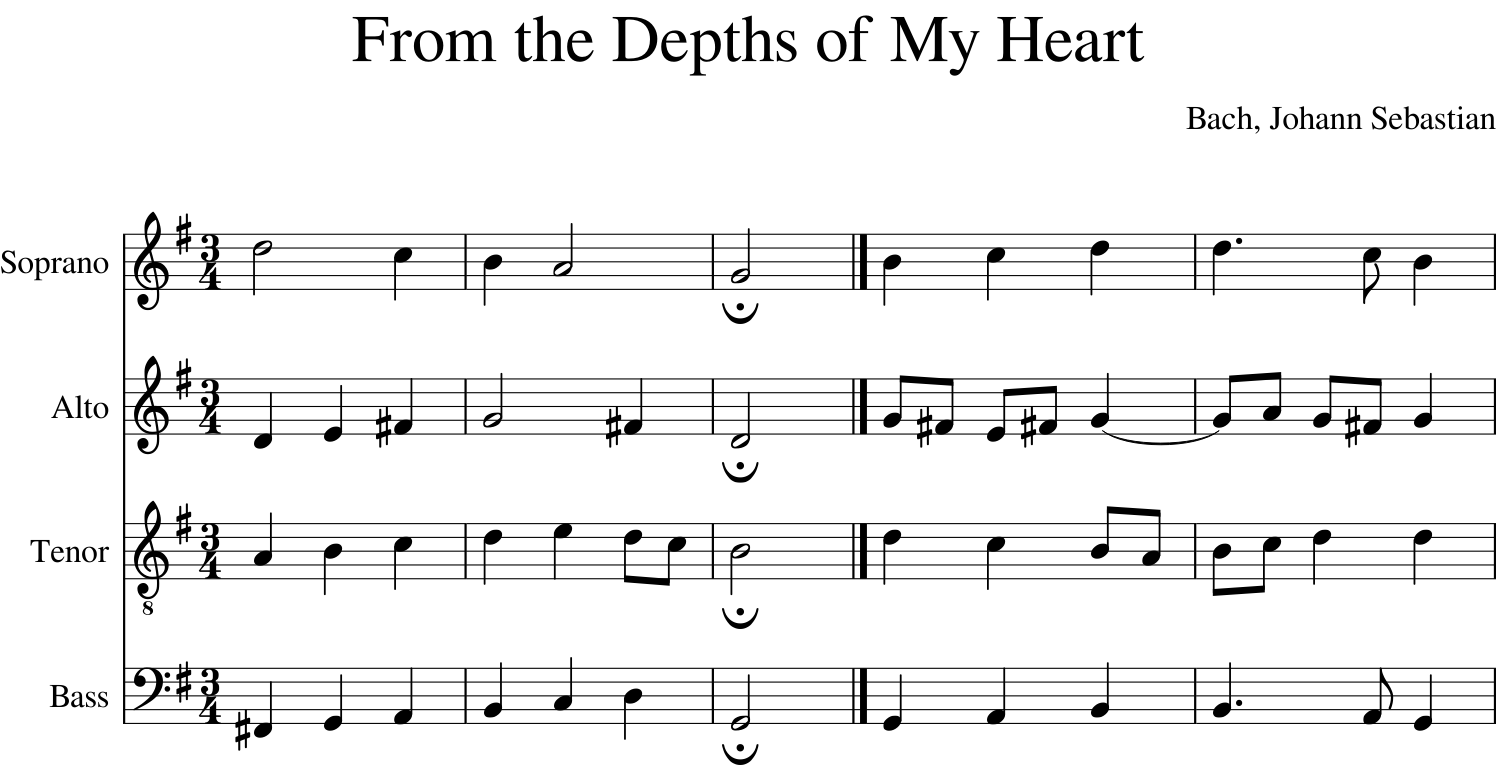

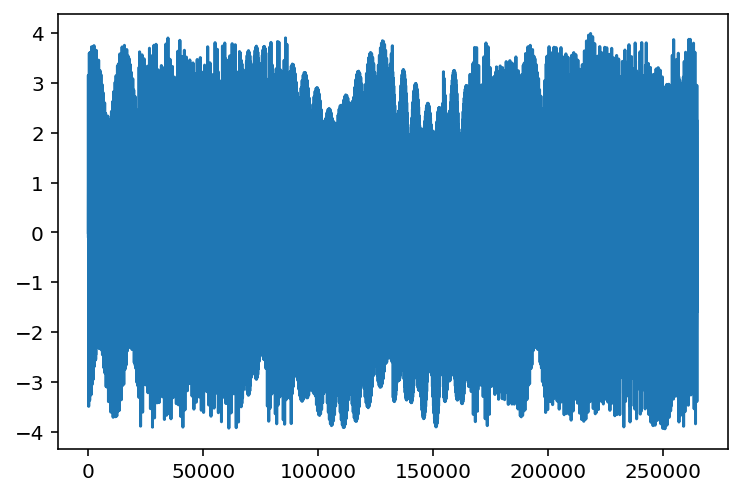

In [ ]:
# returns start and end sample bounds
start_sample, end_sample = source.play(5,8)
plt.plot(source.audio[start_sample:end_sample])

In [ ]:
source.bar_to_samples(12,15)

## Aligning source and target for querying

### `Aligner` class

In [ ]:
class Aligner:

    def __init__(self, source, targets):
        
        self.f_source = []       # the analized source array
        self.f_targets = []      # the array of analyzed targets   
        self.alignments = []     # array of alignments
        
        self.hop_length = 512    # hop size
        self.sr = 22050          # sample rate
        
        
        # feature to analyze with (default chroma_cens)
        self.feature = librosa.feature.chroma_cens   
        # algorithm to align with (default dtw)
        self.aligner = librosa.sequence.dtw   
        

        self.source = source       # 0. fill the source array
        self.load(targets)         # 1. load the target files
        self.analyze(self.feature) # 2. run the analisis
        self.align(self.aligner)   # 3. run the alignment
        
        return None
    
    def load(self, files):
        
        self.targets = []  # the target array of arrays
        for file in filenames:
            y, _ = librosa.load(file, sr=self.sr)
            self.targets.append(y)



    def analyze(self, feature):

        # compute feature on source
        self.f_source = feature(self.source,sr=self.sr,hop_length=self.hop_length)
        # compute feature on targets
        self.f_targets = []
        for t in self.targets:
            self.f_targets.append(feature(t,sr=self.sr,hop_length=self.hop_length))
    
    def align(self, aligner):

        # compute alignments
        self.alignments = []
        for t in self.f_targets:
            self.alignments.append(aligner(self.f_source,t))


    def plot(self, target=0, step_size=60, y_axis='chroma'):
        """
        Plots two chroma features against each other and runs lines
        expressing the aligned moments across plots
        """
        X = self.f_source # the source
        Y = self.f_targets[target] # the target
        optimal_path = self.alignments[target][1] # the optimal path

        p = np.flip(optimal_path)

        fig, ax = plt.subplots(nrows=2,sharex=False, figsize=(12,8))

        librosa.display.specshow(X,ax=ax[0],x_axis='frames',y_axis=y_axis)
        librosa.display.specshow(Y,ax=ax[1],x_axis='frames',y_axis=y_axis)

        ax[0].set_ylabel('Source')
        ax[1].set_ylabel(f'Target  #{target}')

        for i in range(1,len(p[:,0]),step_size):
            tfig = fig.transFigure.inverted()

            coord_in_x = p[:,1][i]
            coord_in_y = p[:,0][i]

            coord1 = tfig.transform(ax[0].transData.transform((coord_in_x,0)))
            coord2 = tfig.transform(ax[1].transData.transform((coord_in_y,12)))

            line = lines.Line2D(
                (coord1[0],coord2[0]),
                (coord1[1],coord2[1]),
                linewidth=4,
                color='green',
                transform=fig.transFigure)

            fig.lines.append(line)

        plt.show()

    def match(self, bounds, target=-1, listen=True):

       
        src_start = bounds[0] // self.hop_length
        src_end   = bounds[1] // self.hop_length

        tgt_bounds = []
        
        if target == -1:
            #do this on all targets
            for i, tgt in enumerate(self.targets):
                tgt_start = [] # <- multiple matches
                tgt_end   = [] # <- multiple matches
                for x in np.flipud(self.alignments[i][1]):
                    s_idx = x[1] * self.hop_length
                    if src_start==x[0]:
                        tgt_start.append(s_idx)
                    elif src_end==x[0]:
                        tgt_end.append(s_idx)
                # take mean of each boundary
                start = int(np.mean(tgt_start))
                end   = int(np.mean(tgt_end))
                if listen:
                    ipd.display(ipd.Audio(tgt[start:end], rate=self.sr))
                tgt_bounds.append([start,end])
        else:
            tgt_start = [] # <- multiple matches
            tgt_end   = [] # <- multiple matches
            for x in np.flipud(self.alignments[target][1]):
                s_idx = x[1] * self.hop_length
                if src_start==x[0]:
                    tgt_start.append(s_idx)
                elif src_end==x[0]:
                    tgt_end.append(s_idx)
            # take mean of each boundary
            start = int(np.mean(tgt_start))
            end   = int(np.mean(tgt_end))
            if listen:
                ipd.display(ipd.Audio(tgt[start:end], rate=self.sr))
            tgt_bounds.append([start,end])

        return tgt_bounds

    # def plot_spectrogram(...)

### Usage

In [ ]:
aligner = Aligner(source.audio, filenames)

In [ ]:
bounds = source.play(15,17) # shows the score and plays the synth excerpt
matched = aligner.match(bounds) # plays matched portion of all targets

Output hidden; open in https://colab.research.google.com to view.

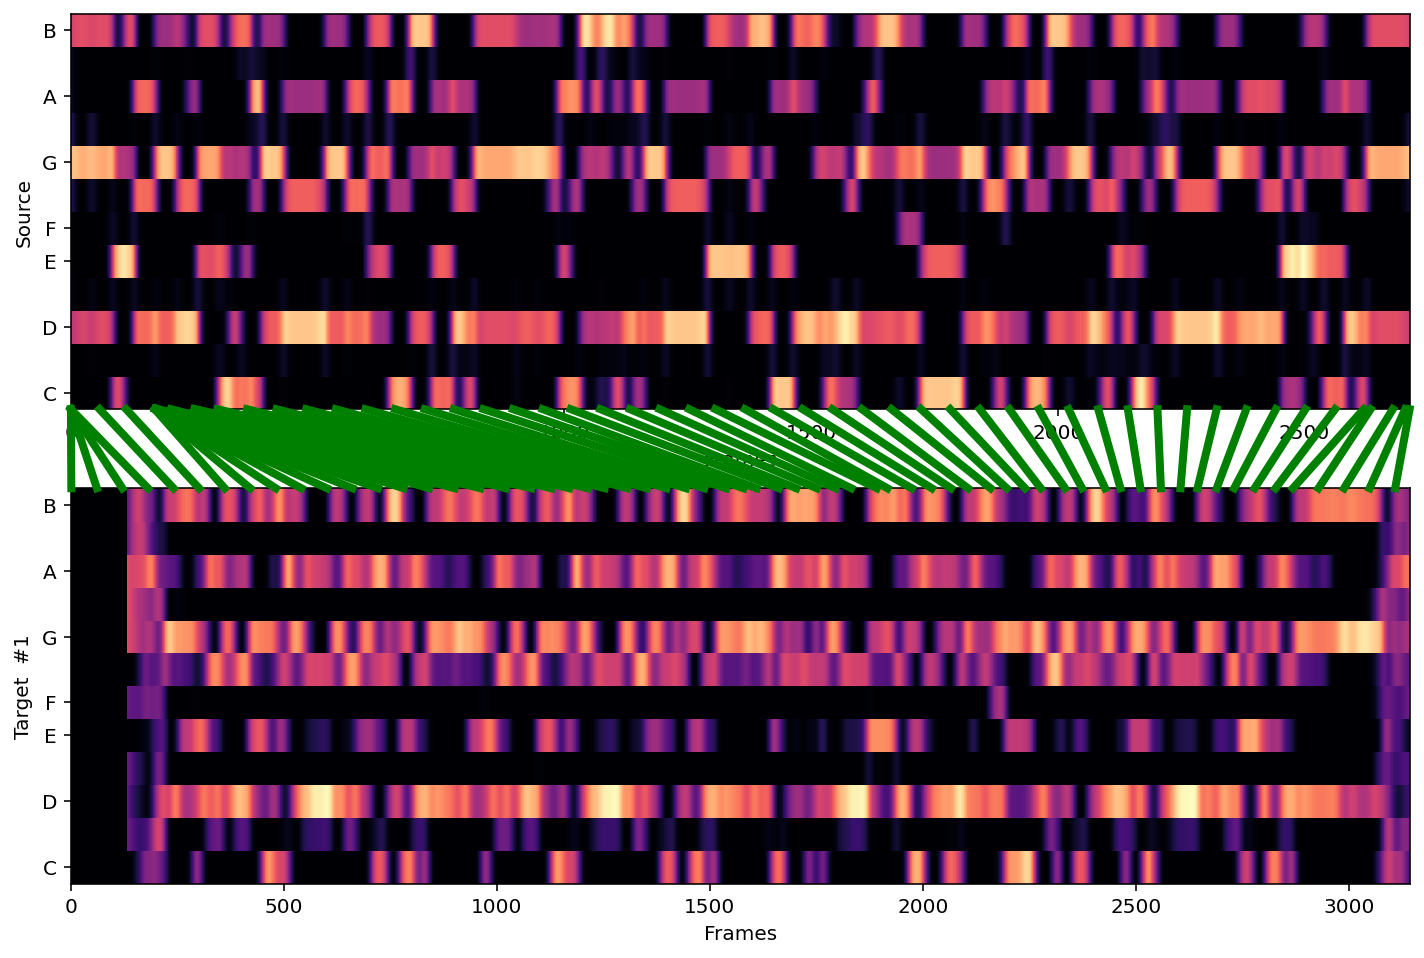

In [ ]:
aligner.plot(1)

# Python Classes

A class in python is a way to structure your data, as well as your functions. Creating a new class creates a new type of object, allowing new instances of that type to be made.



## `Composer` class

In [ ]:
class Composer:
    name = ''

Instantiate the class:

In [ ]:
comp = Composer()

Check what's inside the class attribute `name`:

In [ ]:
print(comp.name)

Bach


Change data inside the instance:

In [ ]:
comp.name = "Bach"

Instantiate the class again to a different variable:

In [ ]:
another_composer = Composer()

Check what's inside:

In [ ]:
print(another_composer.name)

Beethoven


In [ ]:
another_composer.name = "Beethoven"

## Classes have a 'self'
These selves need to be initialized, though.

In [ ]:
class BPM:
    
    def __init__(self, bpm):
        self.bpm = bpm


In [ ]:
song1 = BPM(136)
song1.bpm

136

In [ ]:
song2 = BPM(80)
song2.bpm

80

## How are Classes different than variables? Functions

In [ ]:
class BPM:

    def __init__(self, audio):
        self.audio = audio
        self.get_bpm()

    def get_bpm(self):
        self.bpm = librosa.beat.tempo(self.audio)


In [ ]:
y, sr = librosa.load(librosa.ex('trumpet')) # downloading a librosa example

In [ ]:
song3 = BPM(y)
print("Audio array:")
print(song3.audio)
print("BPM:")
print(song3.bpm)
song3.

In [ ]:
y2,sr2 = librosa.load(librosa.ex('brahms'))

In [ ]:
another_song = BPM(y2)
print("Audio array:")
print(another_song.audio)
print("BPM:")
print(another_song.bpm)

Audio array:
[-3.1496827e-05  4.5770057e-06  6.3310699e-06 ... -1.1488050e-05
 -7.4060167e-06 -8.0729487e-06]
BPM:
[143.5546875]


## Exercise
Add a spectrogram plotting function to the BPM class

### 1. (REVIEW) Put this into a function called `plot_spectrogram`

In [ ]:
def plot_spectrogram(file):
    y, sr = librosa.load(file,offset=10,duration=1)
    mag = np.abs(librosa.stft(y))**2
    mag_db = librosa.power_to_db(mag)
    fig = plt.figure(figsize=(12,8))
    librosa.display.specshow(mag_db,y_axis='log')
    plt.show()
    plt.close(fig)

(review) Run the function on several files:

In [ ]:
for file in filenames:
    plot_spectrogram(file)

### 2. Place the function inside this (slightly changed) BPM class creation

In [ ]:
class BPM:

    def __init__(self, filename):
        self.filename = filename # note this change: now we need to provide a filename instead of an audio array
        self.plot_spectrogram()  # call the plot spectrogram function
        self.get_bpm()           # call the bpm function

    def get_bpm(self):
        self.bpm = librosa.beat.tempo(self.y) # !!! note: this needs self.audio

    def plot_spectrogram(self):
        self.y, sr = librosa.load(self.filename)
        mag = np.abs(librosa.stft(self.y))**2
        mag_db = librosa.power_to_db(mag)
        fig = plt.figure(figsize=(12,8))
        librosa.display.specshow(mag_db,y_axis='log')
        plt.show()
        plt.close(fig)

This would result in a plotted spectrogram, and the bpm printed to screen:

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


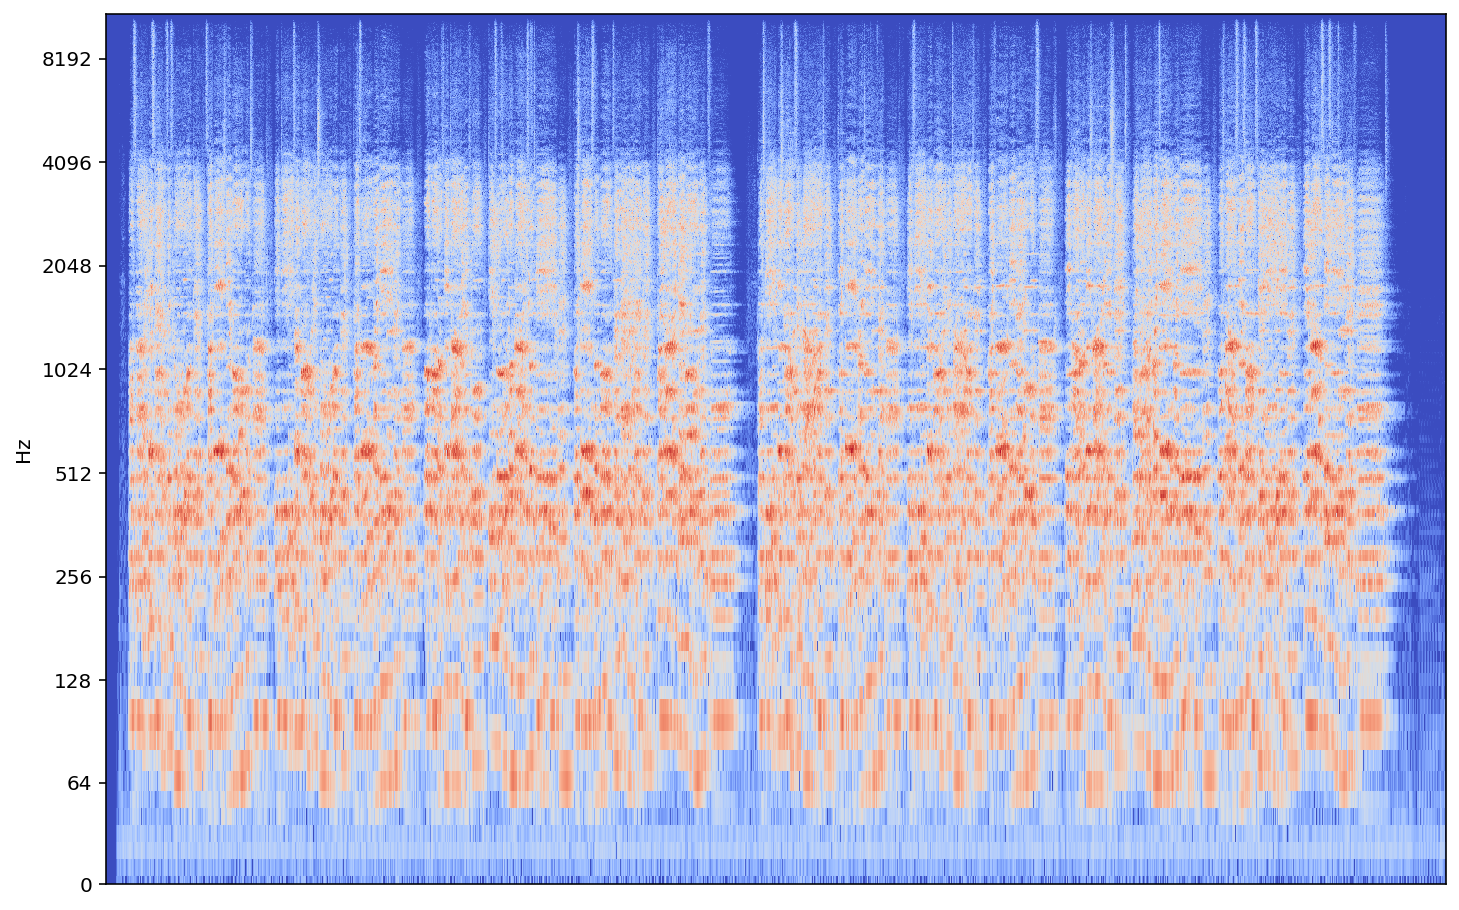

array([123.046875])

In [ ]:
song6 = BPM(filenames[0])
song6.bpm

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


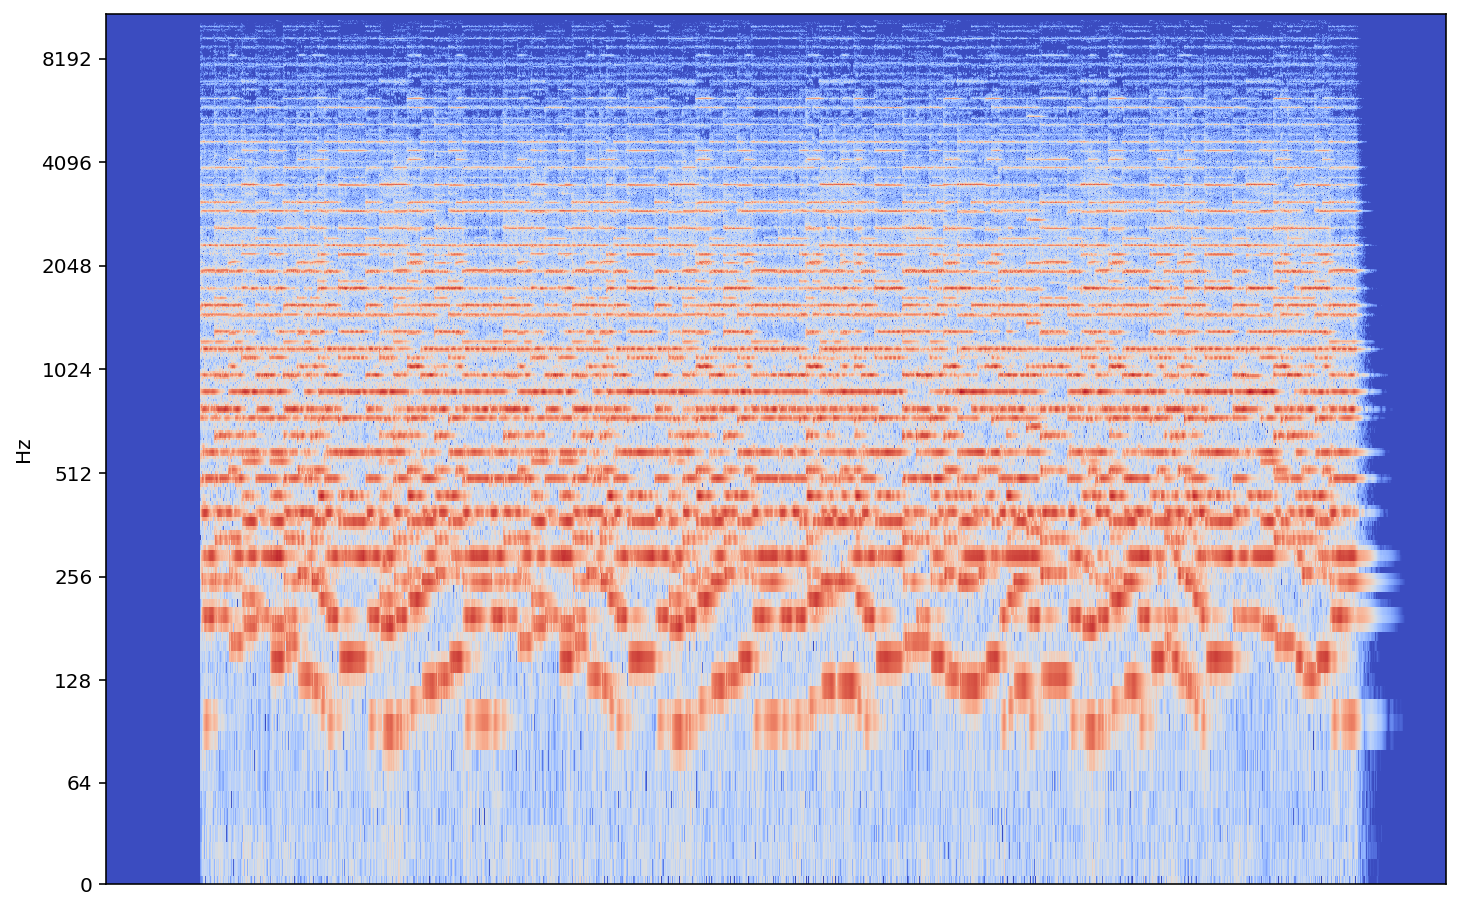

In [ ]:
song6.filename = filenames[1]
song6.plot_spectrogram()